In [6]:
import os
import tensorflow as tf
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt 

In [2]:
os.getcwd()


'/home/t-rex/vrx_ws/src/vision'

In [3]:
LABEL_MAP_PATH = "annotations/label_map.pbtxt"
# # ssd mobilenetpre trained
PATH_TO_SAVED_MODEL = "models/my_model/saved_model"
# PIPELINE_CONFIG_PATH = "models/my_ssd_mobile_netv2_v1_fpn/pipeline.config"
# CKPT_PATH = "models/my_ssd_mobile_netv2_v1_fpn/ckpt-50"

In [4]:
class DetectorTF2:

	def __init__(self, path_to_checkpoint, path_to_labelmap, class_id=None, threshold=0.5):
		# class_id is list of ids for desired classes, or None for all classes in the labelmap
		self.class_id = class_id
		self.Threshold = threshold
		# Loading label map
		self.category_index = self.readLabelMap(path_to_labelmap)
		tf.keras.backend.clear_session()
		start_time = time.time()
		self.detect_fn = tf.saved_model.load(path_to_checkpoint)
		end_time = time.time()
		elapsed_time = end_time - start_time
		print('Done! Took {} seconds'.format(elapsed_time))


	def DetectFromImage(self, img):
		im_height, im_width, _ = img.shape
		# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
		input_tensor = np.expand_dims(img, 0)
		detections = self.detect_fn(input_tensor)

		bboxes = detections['detection_boxes'][0].numpy()
		bclasses = detections['detection_classes'][0].numpy().astype(np.int32)
		bscores = detections['detection_scores'][0].numpy()
		det_boxes = self.ExtractBBoxes(bboxes, bclasses, bscores, im_width, im_height)

		return det_boxes


	def ExtractBBoxes(self, bboxes, bclasses, bscores, im_width, im_height):
		bbox = []
		for idx in range(len(bboxes)):
			if self.class_id is None or bclasses[idx] in self.class_id:
				if bscores[idx] >= self.Threshold:
					y_min = int(bboxes[idx][0] * im_height)
					x_min = int(bboxes[idx][1] * im_width)
					y_max = int(bboxes[idx][2] * im_height)
					x_max = int(bboxes[idx][3] * im_width)
					class_label = self.category_index[int(bclasses[idx])]['name']
					bbox.append([x_min, y_min, x_max, y_max, class_label, float(bscores[idx])])
		return bbox


	def DisplayDetections(self, image, boxes_list, det_time=None):
		if not boxes_list: return image  # input list is empty
		img = image.copy()
		for idx in range(len(boxes_list)):
			x_min = boxes_list[idx][0]
			y_min = boxes_list[idx][1]
			x_max = boxes_list[idx][2]
			y_max = boxes_list[idx][3]
			cls =  str(boxes_list[idx][4])
			score = str(np.round(boxes_list[idx][-1], 2))

			text = cls + ": " + score
			cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)
			cv2.rectangle(img, (x_min, y_min - 20), (x_min, y_min), (255, 255, 255), -1)
			cv2.putText(img, text, (x_min + 5, y_min - 7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

		if det_time != None:
			fps = round(1000. / det_time, 1)
			fps_txt = str(fps) + " FPS"
			cv2.putText(img, fps_txt, (25, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)

		return img
	def readLabelMap(self, label_map_path):
		item_id = None
		item_name = None
		items = {}
		
		with open(label_map_path, "r") as file:
			for line in file:
				line.replace(" ", "")
				if line == "item{":
					pass
				elif line == "}":
					pass
				elif "id" in line:
					item_id = int(line.split(":", 1)[1].strip())
				elif "name" in line:
					item_name = line.split(":", 1)[1].replace("'", "").strip()

				if item_id is not None and item_name is not None:
					items[item_id] = {"id":item_id, "name": item_name} 
					item_id = None
					item_name = None

		return items

In [5]:
det = DetectorTF2(PATH_TO_SAVED_MODEL, LABEL_MAP_PATH, class_id=None, threshold=0.2)

2022-03-16 19:32:17.071505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-16 19:32:17.072041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/t-rex/general_env/lib/python3.8/site-packages/cv2/../../lib64:
2022-03-16 19:32:17.072110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/t-rex/general_env/lib/python3.8/site-packages/cv2/../../lib64:
2022-03-16 19:32:17.072173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerro

Done! Took 8.38063645362854 seconds


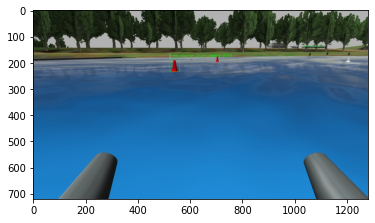

In [11]:
img = plt.imread("images/frame0000.jpg")
bboxes = det.DetectFromImage(img)
plt.imshow(det.DisplayDetections(img, bboxes))

In [12]:
bboxes

[[523, 185, 559, 235, 'mb_marker_buoy_black', 0.2587009072303772],
 [523, 185, 559, 235, 'mb_marker_buoy_red', 0.2086256742477417]]

In [16]:
i = 0
x_center = int((bboxes[i][2] - bboxes[i][0])/2)
y_center = int((bboxes[i][1] - bboxes[i][3])/2)

In [ ]:
def appendBoxCenter(bboxes):
    """Return bboxes with center point added to bboxes
    args: 
        bboxes - 
    """
    for i in range(len(bboxes)):
        x_center = int((bboxes[i][2] - bboxes[i][0])/2)
        y_center = int((bboxes[i][1] - bboxes[i][3])/2)
        bboxes[i].append(x_center, y_center)
    return bboxes